# Modelo de Machine Learning

El objetivo del presente modelo de ML es abordar la incertidumbre de la apertura de un nuevo restaurante latino.

## 1. Definir el problema y el target:
- Problema: Determinar si un restaurante latino puede tener éxito.
- Target: Se tomará como variable objetivo (y) a la columna is_open, el cual es una variable binaria, donde 1 es éxito y 0 fracaso.

Importamos las librerías a utilizar

In [142]:
import pandas as pd
import numpy as np
import json # Para trabajar con JSON
from pandas import json_normalize
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")
#plt.rcParams["figure.figsize"] = (12, 6)

# libreriías para el modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

## 2. Preparamos los datos

Cargamos el datasets de restaurantes latinos 

In [143]:
file_path='D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/restaurantes_latinos_filtrados.csv'

In [144]:
df1 = pd.read_csv(file_path)

In [145]:
df1.head(2)

,business_id,name,restaurante_categoria,address,city,state_id,state_name,abbreviation,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsTakeOut,WiFi,RestaurantsAttire,NoiseLevel
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,['restaurante mexicano'],10160 Ulmerton Rd,Largo,1,Florida,FL,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants",True,True,False,True,no,ucasual,uaverage
1,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,['restaurante mexicano'],8745 Gunn Hwy,Odessa,1,Florida,FL,33556,28.092136,-82.578574,4.0,82.0,1,"Restaurants, Mexican, American (Traditional)",True,True,True,True,u no,ucasual,uquiet


Elimanos columnas que no se utilizaran en el modelo

In [146]:
drop_columns = ['state_id','city','abbreviation','postal_code','categories','HasTV','WiFi','RestaurantsAttire', 'NoiseLevel']
df1 = df1.drop(columns=drop_columns, axis=1)

In [147]:
# Verificamos los resultados
df1.head(2)

,business_id,name,restaurante_categoria,address,state_name,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,OutdoorSeating,RestaurantsTakeOut
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,['restaurante mexicano'],10160 Ulmerton Rd,Florida,27.894167,-82.779866,3.0,19.0,1,True,False,True
1,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,['restaurante mexicano'],8745 Gunn Hwy,Florida,28.092136,-82.578574,4.0,82.0,1,True,True,True


In [148]:
# Renombramos algunas columnas
df1= df1.rename(columns={'business_id':'id','stars':'avg_rating','review_count':'review','BusinessAcceptsCreditCards':'CreditCards','RestaurantsTakeOut':'TakeOut' })

In [149]:
# Limpiamos la columna `restaurante_categoria` para dejar solo el texto
df1['restaurante_categoria'] = df1['restaurante_categoria'].str.strip("[]").str.replace("'", "").str.strip()

In [150]:
# Convertimos las columnas: `CreditCards`, `OutdoorSeating`, y `TakeOut` a valores 0 y 1
bool_columns = ['CreditCards', 'OutdoorSeating', 'TakeOut']
for col in bool_columns:
    df1[col] = df1[col].apply(lambda x: 1 if x == True or x == 'True' else 0)

In [151]:
# Verificamos los cambios
df1.head(2)

,id,name,restaurante_categoria,address,state_name,latitude,longitude,avg_rating,review,is_open,CreditCards,OutdoorSeating,TakeOut
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,restaurante mexicano,10160 Ulmerton Rd,Florida,27.894167,-82.779866,3.0,19.0,1,1,0,1
1,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,restaurante mexicano,8745 Gunn Hwy,Florida,28.092136,-82.578574,4.0,82.0,1,1,1,1


In [152]:
# Creamos variables dummy para la columna `restaurante_categoria`, asegurándonos de que sean 0 y 1
dummies = pd.get_dummies(df1['restaurante_categoria'], prefix='cat', drop_first=True)

# Nos aseguramos de que las variables dummy sean enteros (0 o 1)
dummies = dummies.astype(int)

# Añadimos las variables dummy al DataFrame original
df1 = pd.concat([df1.drop(columns=['restaurante_categoria']), dummies], axis=1)

In [153]:
# Verificamos que las columnas dummy sean binarias
dummies.head(2)

,cat_restaurante brasileño,cat_restaurante caribeño,cat_restaurante centroamericano,cat_restaurante colombiano,cat_restaurante cubano,cat_restaurante dominicano,cat_restaurante latinoamericano,cat_restaurante mexicano,cat_restaurante peruano,cat_restaurante venezolano
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0


Cargamos los datos Demográficos

In [154]:
file_path = 'D:/2024/HenryData/PF/Datos_Crudos/Censo/states_promedio.csv'

In [155]:
df_pobla = pd.read_csv(file_path)

In [156]:
df_pobla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_id             6 non-null      int64  
 1   state_name           6 non-null      object 
 2   abbreviation         6 non-null      object 
 3   total_population     6 non-null      int64  
 4   hispanic_population  6 non-null      int64  
 5   avg_income           6 non-null      float64
dtypes: float64(1), int64(3), object(2)
memory usage: 420.0+ bytes


In [157]:
df_pobla.head(7)

,state_id,state_name,abbreviation,total_population,hispanic_population,avg_income
0,6,Arizona,AZ,6707875,2030951,45892.43
1,2,California,CA,38773436,14744533,63364.21
2,1,Florida,FL,20158603,4695397,48321.24
3,5,Illinois,IL,12829297,2113775,53467.05
4,4,New York,NY,19664161,3559667,59272.35
5,3,Texas,TX,27337059,10704104,50373.87


Unimos los DataFrames

In [158]:
# Unir el DataFrame del modelo con el DataFrame de población
df_model = df1.merge(df_pobla[['state_name', 'total_population', 'hispanic_population', 'avg_income']], 
              on='state_name', 
              how='left')

In [159]:
# Verificar la integración
df_model.head(2)

,id,name,address,state_name,latitude,longitude,avg_rating,review,is_open,CreditCards,OutdoorSeating,TakeOut,cat_restaurante brasileño,cat_restaurante caribeño,cat_restaurante centroamericano,cat_restaurante colombiano,cat_restaurante cubano,cat_restaurante dominicano,cat_restaurante latinoamericano,cat_restaurante mexicano,cat_restaurante peruano,cat_restaurante venezolano,total_population,hispanic_population,avg_income
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Florida,27.894167,-82.779866,3.0,19.0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,20158603,4695397,48321.24
1,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,8745 Gunn Hwy,Florida,28.092136,-82.578574,4.0,82.0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,20158603,4695397,48321.24


In [160]:
# Verificar valores faltantes en las columnas nuevas
print("Valores nulos después de la unión:")
print(df_model[['total_population', 'hispanic_population', 'avg_income']].isnull().sum())

Valores nulos después de la unión:
total_population       0
hispanic_population    0
avg_income             0
dtype: int64


In [161]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               2098 non-null   object 
 1   name                             2098 non-null   object 
 2   address                          2074 non-null   object 
 3   state_name                       2098 non-null   object 
 4   latitude                         2098 non-null   float64
 5   longitude                        2098 non-null   float64
 6   avg_rating                       2098 non-null   float64
 7   review                           2098 non-null   float64
 8   is_open                          2098 non-null   int64  
 9   CreditCards                      2098 non-null   int64  
 10  OutdoorSeating                   2098 non-null   int64  
 11  TakeOut                          2098 non-null   int64  
 12  cat_restaurante bras

## 3. Feature Engineering

Se utiliza la metodología de ingeniería de características para seleccionar las variables más relevantes para el modelo ML

In [162]:
# Se crea el ratio de población hispana en df_model
df_model['hispanic_population_ratio'] = df_model['hispanic_population'] / df_model['total_population']

# Verificar las primeras filas
print("Primeras filas con la proporción de población hispana:")
print(df_model[['state_name', 'hispanic_population_ratio']].head())

Primeras filas con la proporción de población hispana:
   state_name  hispanic_population_ratio
0     Florida                   0.232923
1     Florida                   0.232923
2  California                   0.380274
3     Florida                   0.232923
4  California                   0.380274


In [163]:
# Normalizamos ingresos promedio
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_model['avg_income_normalized'] = scaler.fit_transform(df_model[['avg_income']])

# Verificar normalización
print("Ingresos normalizados:")
print(df_model[['avg_income', 'avg_income_normalized']].head())

Ingresos normalizados:
   avg_income  avg_income_normalized
0    48321.24               0.139013
1    48321.24               0.139013
2    63364.21               1.000000
3    48321.24               0.139013
4    63364.21               1.000000


In [164]:
# Normalizamos avg_rating y review
df_model['avg_rating_normalized'] = scaler.fit_transform(df_model[['avg_rating']])
df_model['review_normalized'] = scaler.fit_transform(df_model[['review']])

# Creamos una métrica de popularidad combinada
df_model['popularity_score'] = df_model['avg_rating_normalized'] * 0.6 + df_model['review_normalized'] * 0.4

# Verificar las primeras filas
print("Primeras filas con métricas de popularidad:")
print(df_model[['avg_rating', 'review', 'popularity_score']].head())

Primeras filas con métricas de popularidad:
   avg_rating  review  popularity_score
0         3.0    19.0          0.301463
1         4.0    82.0          0.458044
2         4.0    49.0          0.454597
3         5.0     6.0          0.600104
4         4.0   189.0          0.469222


In [165]:
# Verificamos
df_model.head(2)

,id,name,address,state_name,latitude,longitude,avg_rating,review,is_open,CreditCards,OutdoorSeating,TakeOut,cat_restaurante brasileño,cat_restaurante caribeño,cat_restaurante centroamericano,cat_restaurante colombiano,cat_restaurante cubano,cat_restaurante dominicano,cat_restaurante latinoamericano,cat_restaurante mexicano,cat_restaurante peruano,cat_restaurante venezolano,total_population,hispanic_population,avg_income,hispanic_population_ratio,avg_income_normalized,avg_rating_normalized,review_normalized,popularity_score
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Florida,27.894167,-82.779866,3.0,19.0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,20158603,4695397,48321.24,0.232923,0.139013,0.50,0.003656,0.301463
1,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,8745 Gunn Hwy,Florida,28.092136,-82.578574,4.0,82.0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,20158603,4695397,48321.24,0.232923,0.139013,0.75,0.020110,0.458044


In [166]:
# Eliminar columnas redundantes
drop_columns=['id','name','address','state_name','avg_rating','review','total_population','hispanic_population','avg_income','avg_rating_normalized','review_normalized']
df_model = df_model.drop(columns=drop_columns, axis=1)

## 4. Dividir el Dataset

Dividimos el dataset en:

Entrenamiento (70%): Para ajustar el modelo.
Prueba (30%): Para evaluar el modelo.

In [167]:
from sklearn.model_selection import train_test_split

# Seleccionar las columnas relevantes para el modelo
X = df_model.drop(columns=['is_open'])  # Variables independientes, se eliminan columnas redudantes
y = df_model['is_open']  # Variable objetivo

In [168]:
# Dividir en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [169]:
# Verificar las formas de los conjuntos
print("Tamaño de los conjuntos:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Tamaño de los conjuntos:
X_train: (1468, 18), y_train: (1468,)
X_test: (630, 18), y_test: (630,)


In [170]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

## 5. Selección del Modelo

In [171]:
# Importamos las liberías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [172]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42) # árboles en el bosque=50, profundidad de cada árbol=8

In [173]:
# Entrenar el modelo
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=42)

In [174]:
# Predicciones
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [175]:
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilidades para el cálculo del ROC-AUC

## 6. Evaluación del Modelo

Usaremos métricas como:

Accuracy: Porcentaje de predicciones correctas.

F1-score: Equilibrio entre precisión y sensibilidad.

ROC-AUC: Para evaluar separabilidad.

Accuracy y F1-score:

In [176]:
# Evaluar el modelo
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Resultados del Random Forest:")
print(f"Precisión en el conjunto de entrenamiento: {train_accuracy:.2f}")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
print("\nReporte de clasificación (conjunto de prueba):")
print(classification_report(y_test, y_test_pred))

Resultados del Random Forest:
Precisión en el conjunto de entrenamiento: 0.75
Precisión en el conjunto de prueba: 0.63

Reporte de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           0       0.45      0.63      0.52       201
           1       0.79      0.63      0.70       429

    accuracy                           0.63       630
   macro avg       0.62      0.63      0.61       630
weighted avg       0.68      0.63      0.65       630



Interpretación:
- Precisión en el conjunto de entrenamiento (0.75): Esto significa que el modelo clasificó correctamente el 75% de las observaciones en el conjunto de datos con el que fue entrenado.

- Precisión en el conjunto de prueba (0.63): Esta métrica es más importante, ya que evalúa la capacidad del modelo para generalizar a nuevos datos. Un valor de 0.63 indica que el modelo clasificó correctamente el 63% de las observaciones en el conjunto de prueba. La disminución en la precisión respecto al conjunto de entrenamiento sugiere un posible sobreajuste. Sin embargo, esta métrica se analizará con la validación cruzada, pues esta disminución en la precisión en el conjunto de entrenamiento sugiere un sobreajuste, es decir, el modelo está aprendiendo los detalles específicos del conjunto de entrenamiento y no generaliza bien a nuevos datos.

- Reporte de clasificación:
    - Precisión por clase: La precisión para la clase 0 es de 0.45 y para la clase 1 es de 0.79. Esto indica que el modelo tiene más dificultades para clasificar correctamente la clase 0.
    - Recall por clase: El recall para ambas clases es de 0.63. Esto significa que el modelo recuperó el 63% de los casos positivos de cada clase.
    - F1-score: El F1-score es la media armónica de precisión y recall, y proporciona una medida balanceada del desempeño del modelo. Un F1-score de 0.52 para la clase 0 y 0.70 para la clase 1 sugiere que el modelo tiene un mejor desempeño en la clase 1.

Curva ROC-AUC

In [177]:
from sklearn.metrics import roc_curve, roc_auc_score

AUC: 0.6861264771712533


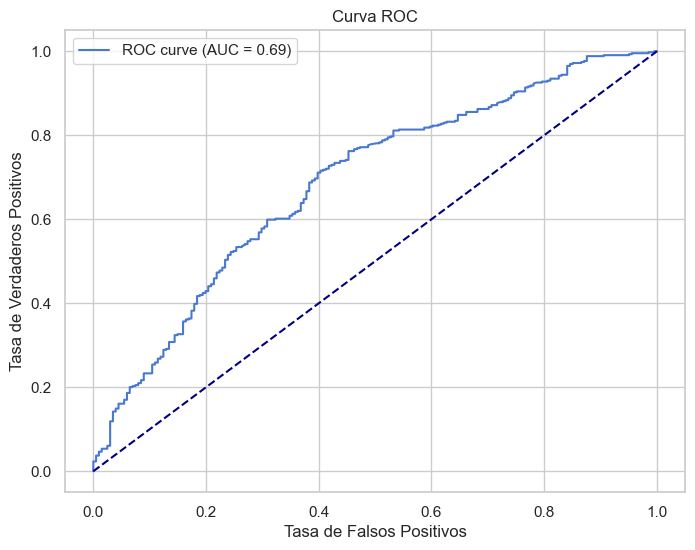

In [178]:
# Calcular los puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc}')

# Visualizar la curva ROC
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

Interpretación: se observa que el modelo tiene una capacidad moderada de predicción, es decir puede distinguir entre restaurantes éxitos y no, pero no con una precisión muy alta.

Matriz de confusión

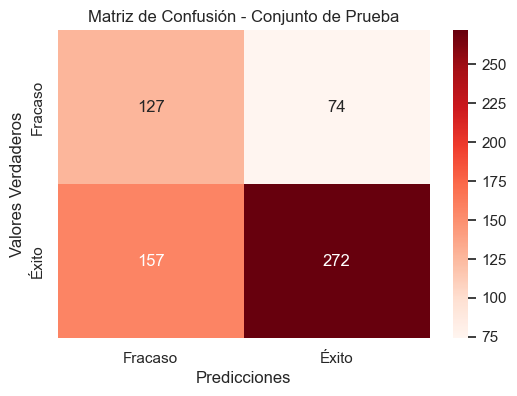

In [179]:
# Matriz de confusión en prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()

*Interpretación:* 

- Verdaderos Positivos (VP): 272. El modelo predijo correctamente que 272 restaurantes serían un éxito, y efectivamente lo fueron.
- Verdaderos Negativos (VN): 127. El modelo predijo correctamente que 127 restaurantes serían un fracaso, y efectivamente lo fueron.
- Falsos Positivos (FP): 74. El modelo predijo erróneamente que 74 restaurantes serían un éxito, pero en realidad fueron un fracaso.
- Falsos Negativos (FN): 157. El modelo predijo erróneamente que 157 restaurantes serían un fracaso, pero en realidad fueron un éxito.

**Conclusiones:**
- El modelo Random Forest, muestra un buen desempeño en la predicción del éxito de restaurantes latinos, ya que el modelo ha logrado predecir correctamente un alto porcentaje de casos que fueron un éxito.
-  El modelo parece ser mejor en predecir los restaurantes que serán un éxito que aquellos que serán un fracaso. Esto se puede ver en el mayor número de Verdaderos Positivos (VP) en comparación con los Verdaderos Negativos (VN).
- Es importante notar que el número de Falsos Negativos (FN) es considerable. Esto significa que el modelo está dejando pasar algunos restaurantes que podrían ser un éxito. En el contexto de abrir un restaurante, esto podría resultar en una pérdida de oportunidades de negocio.

Validación Cruzada

In [180]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, cross_validate

In [181]:
k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [182]:
# Realizar validación cruzada usando la métrica de precisión
scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
# Realizar validación cruzada usando la métrica de F1-score
scores_f1 = cross_val_score(rf_model, X, y, cv=kf, scoring='f1')

In [183]:
# Promediar los resultados de los k-folds
mean_score = scores.mean()
std_score = scores.std()
print(f'Precisión media con validación cruzada de {k} folds: {mean_score}')
print(f'Desviación estándar de la precisión: {std_score}')

mean_f1 = scores_f1.mean()
print(f'F1-score medio con validación cruzada: {mean_f1}')

Precisión media con validación cruzada de 5 folds: 0.6911569496533697
Desviación estándar de la precisión: 0.022184153517041314
F1-score medio con validación cruzada: 0.8096631295391383


Interpretación:
- Precisión media: Indica que en promedio, el modelo clasificó correctamente el 69.11% de las observaciones. Esto nos da una idea general de la capacidad del modelo para hacer predicciones correctas.
- Desviación estándar de la precisión: Mide la variabilidad de la precisión a través de los diferentes folds. Un valor bajo, como el obtenido en este caso (0.022), sugiere que el modelo es relativamente estable y que los resultados no fluctúan demasiado entre los diferentes folds.
- F1-score medio: El F1-score es una medida armónica de precisión y recall, y proporciona una medida más balanceada del desempeño del modelo, especialmente cuando las clases están desbalanceadas. Un valor de 0.809 indica que el modelo tiene un buen desempeño en términos de precisión y recall.

In [184]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print(f"Accuracy en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy en validación cruzada: 0.6954 ± 0.0097


Interpretación:
Esta métrica "Accuracy en validación cruzada", nos indica el porcentaje promedio de predicciones correctas que nuestro modelo ha realizado en un proceso de validación cruzada. En este caso, el modelo ha sido correcto en aproximadamente el 69.54% de las predicciones. El valor ± 0.0097 representa el intervalo de confianza de esta medida, lo que significa que podemos estar razonablemente seguros de que la precisión real del modelo se encuentra entre 0.6857 y 0.7051.

**Conlusión:**
- El modelo muestra un buen desempeño en términos de precisión y F1-score, lo cual indica que es capaz de clasificar correctamente una proporción significativa de las observaciones.
- La baja desviación estándar de la precisión sugiere que el modelo es relativamente estable y que los resultados son generalizables a nuevos datos.
- El alto F1-score indica que el modelo logra un buen equilibrio entre la capacidad de identificar correctamente los casos positivos (recall) y la capacidad de evitar clasificar incorrectamente los casos negativos como positivos (precision).
- En general los resultados de la validación cruzada sugieren que el modelo de Random Forest es un buen candidato para predecir el éxito de la apertura de un nuevo restaurante latino en Estados Unidos. 

Importancia de características

In [185]:
# Importancia de características
feature_importances = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print(feature_importances.head(10))  # Mostrar las 10 más importantes

                Característica  Importancia
17            popularity_score     0.333560
0                     latitude     0.253604
1                    longitude     0.241444
16       avg_income_normalized     0.026755
12    cat_restaurante mexicano     0.022129
15   hispanic_population_ratio     0.021402
8   cat_restaurante colombiano     0.014102
9       cat_restaurante cubano     0.013919
6     cat_restaurante caribeño     0.013274
2                  CreditCards     0.009286


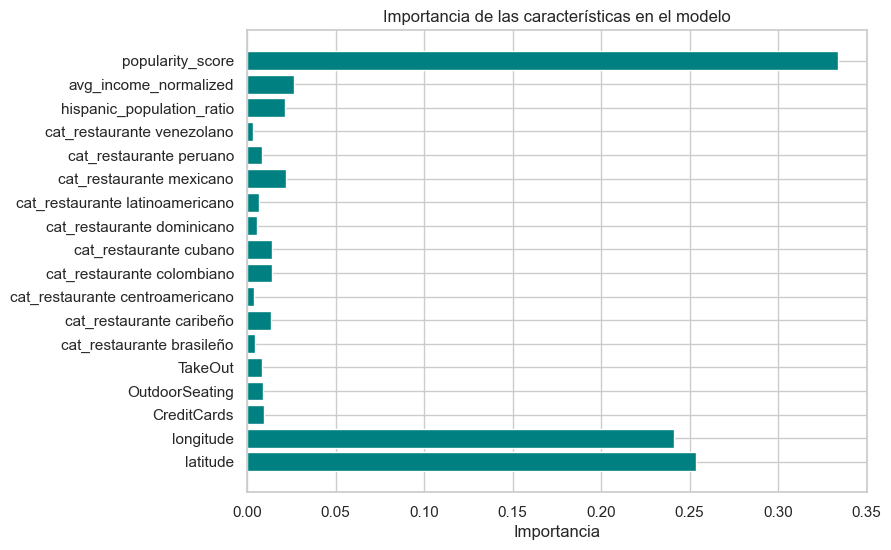

In [186]:
# Importancia de las características
importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='teal')
plt.xlabel('Importancia')
plt.title('Importancia de las características en el modelo')
plt.show()

Interpretación:

*Características más importantes:*
- popularity_score: Esta característica parece ser la más influyente en la predicción del éxito del restaurante. Esto sugiere que la popularidad previa de un lugar es un fuerte indicador de su futuro éxito.
- avg_income_normalized: El ingreso promedio normalizado de la zona también tiene una alta importancia, lo que indica que el poder adquisitivo de la clientela potencial es un factor clave.
- longitude y latitude: La ubicación geográfica del restaurante (representada por las coordenadas de longitud y latitud) también juega un papel importante. Esto podría deberse a factores como la competencia, la densidad de población o la accesibilidad.

*Características menos importantes:*
- Características relacionadas con el tipo de cocina: Las características que indican el tipo de cocina venezolana y centroamericana, parecen tener una importancia relativamente baja. Esto podría significar que el tipo de cocina no es un factor determinante para el éxito en este modelo, o que otras características están dominando la predicción.
- Características relacionadas con los servicios: Características como "TakeOut", "OutdoorSeating" y "CreditCards" también tienen una importancia baja, lo que sugiere que estos servicios no son los principales factores que influyen en el éxito del restaurante.

## 7. Conclusión sobre el modelo y su implementación:

Basándonos en el análisis de las métricas obtenidas durante la validación cruzada, podemos concluir que el modelo *Random Forest* está generalizando de manera satisfactoria con nuevos datos, lo que sugiere un bajo riesgo de sobreajuste. No obstante, es fundamental considerar la **importancia de las características** que contribuyen al modelo para tomar decisiones más informadas y estratégicas al momento de implementar el modelo.

In [187]:
# Guardamos el modelo ya entrenado
import joblib

#rf_model ya está entrenado
joblib.dump(rf_model, "modelo_restaurante.pkl")

['modelo_restaurante.pkl']

## 8. Prueba de Concepto del Modelo Random Forest

In [188]:
nuevo_restaurante1 = pd.DataFrame([{
    "latitude": 34.052235,  # Latitud de Los Ángeles, por ejemplo
    "longitude": -118.243683,  # Longitud de Los Ángeles
    "CreditCards": 1,  # Acepta tarjetas
    "OutdoorSeating": 1,  # Tiene asientos exteriores
    "TakeOut": 1,  # Tiene servicio para llevar
    "cat_restaurante brasileño": 0, 
    "cat_restaurante caribeño": 0,  
    "cat_restaurante centroamericano": 0,
    "cat_restaurante colombiano": 0,
    "cat_restaurante cubano": 0,
    "cat_restaurante dominicano": 0,
    "cat_restaurante latinoamericano": 0,
    "cat_restaurante mexicano": 1, # Restaurante mexicano
    "cat_restaurante peruano": 0,
    "cat_restaurante venezolano": 0,
    "hispanic_population_ratio": 0.45,  # Proporción de población hispana
    "avg_income_normalized": 0.85,  # Nivel de ingresos en la zona
    "popularity_score": 0.75  # Puntuación de popularidad del área
}])

In [189]:
prediccion = rf_model.predict(nuevo_restaurante1)
print("¿El restaurante latino con esas características podría tener éxito?", "Sí" if prediccion[0] == 1 else "No")

¿El restaurante latino con esas características podría tener éxito? Sí


In [190]:
probabilidad = rf_model.predict_proba(nuevo_restaurante1)
print(f"Probabilidad de éxito: {probabilidad[0][1]:.2f}")

Probabilidad de éxito: 0.81


-------

## 9. Documentamos el modelo alternativo trabajado: Modelo de Regresión Logística

Se documentó el modelo de regresión logística como punto de partida y para demostrar que se exploraron diversas opciones de modelado. Sin embargo, tras una evaluación exhaustiva, se optó por el modelo de Random Forest debido a sus siguientes ventajas:

- Mayor capacidad de captura de relaciones no lineales: Random Forest es capaz de modelar relaciones más complejas entre las variables predictoras y la variable objetivo, lo que puede llevar a una mayor precisión en predicciones.

- Menor sensibilidad al sobreajuste: Al construir múltiples árboles de decisión y promediar sus resultados, Random Forest reduce el riesgo de sobreajuste, lo que resulta en un mejor desempeño en datos nuevos.

- Importancia de las variables: Random Forest proporciona una medida de importancia de cada variable, lo que facilita la interpretación del modelo y la identificación de los factores más influyentes en la predicción.


Aunque la regresión logística es un modelo sólido, en este caso específico, Random Forest demostró ser una herramienta más poderosa para capturar la complejidad de los datos y obtener mejores resultados predictivos.

In [191]:
# Importamos la librería del modelo
from sklearn.linear_model import LogisticRegression

In [192]:
# Seleccionar las columnas relevantes para el modelo
X = df_model.drop(columns=['is_open'])  # Variables independientes, se eliminan columnas redudantes
y = df_model['is_open']  # Variable objetivo

In [193]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [195]:
# Crear el modelo
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
log_reg.fit(X_train_balanced, y_train_balanced )

LogisticRegression(max_iter=1000, random_state=42)

In [196]:
# Predicciones
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [197]:
# Métricas
print("\nMétricas Regresión Logística:")
print("Accuracy en entrenamiento:", accuracy_score(y_train, y_train_pred))
print("Accuracy en prueba:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Métricas Regresión Logística:
Accuracy en entrenamiento: 0.5504087193460491
Accuracy en prueba: 0.5349206349206349

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.62      0.47       208
           1       0.72      0.50      0.59       422

    accuracy                           0.53       630
   macro avg       0.55      0.56      0.53       630
weighted avg       0.61      0.53      0.55       630



Interpretación:

- Accuracy en entrenamiento (0.55): Indica que el modelo clasificó correctamente el 55% de las observaciones en el conjunto de entrenamiento.
- Accuracy en prueba (0.53): Esta métrica es más importante, ya que evalúa la capacidad del modelo para generalizar a nuevos datos. Un valor de 0.53 indica que el modelo clasificó correctamente el 53% de las observaciones en el conjunto de prueba. La disminución en la precisión respecto al conjunto de entrenamiento, aunque pequeña.

- Classification Report:
    - Precisión por clase: La precisión para la clase 0 es de 0.38 y para la clase 1 es de 0.72. Esto indica que el modelo tiene más dificultades para clasificar correctamente la clase 0.
    - Recall por clase: El recall para la clase 0 es de 0.62 y para la clase 1 es de 0.50. Esto significa que el modelo tiene un mejor desempeño en identificar los casos positivos de la clase 0.
    - F1-score: El F1-score es la media armónica de precisión y recall, y proporciona una medida balanceada del desempeño del modelo. Un F1-score de 0.47 para la clase 0 y 0.59 para la clase 1 sugiere que el modelo tiene un mejor desempeño en la clase 1.

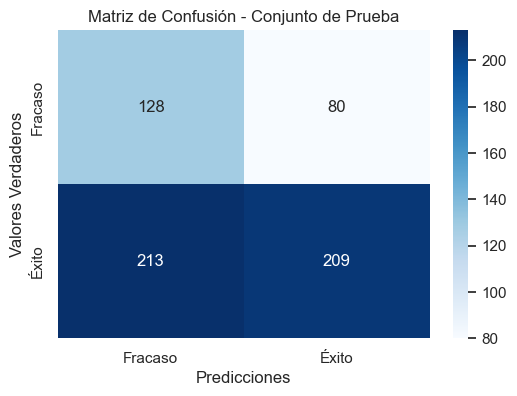

In [198]:
# Matriz de confusión en prueba
conf_matrix_test2 = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test2, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()

*Interpretación:* 

- Verdaderos Positivos (VP): 209. El modelo predijo correctamente que 209 restaurantes serían un éxito, y efectivamente lo fueron.
- Verdaderos Negativos (VN): 128. El modelo predijo correctamente que 128 restaurantes serían un fracaso, y efectivamente lo fueron.
- Falsos Positivos (FP): 80. El modelo predijo erróneamente que 80 restaurantes serían un éxito, pero en realidad fueron un fracaso.
- Falsos Negativos (FN): 213. El modelo predijo erróneamente que 2013 restaurantes serían un fracaso, pero en realidad fueron un éxito.

**Conclusiones:**
- El modelo de Regresión logística, parece ser bastante bueno a la hora de predecir los restaurantes que serán un éxito. Esto se evidencia por el alto número de Verdaderos Positivos (VP).
-  El modelo tiene más dificultades para predecir los restaurantes que serán un fracaso. El número de Falsos Negativos (FN) es considerablemente alto, lo que indica que el modelo está clasificando erróneamente muchos restaurantes que en realidad sí fracasaron como si fueran a tener éxito.

In [199]:
# Crear un DataFrame con los coeficientes
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coeff_df)

                            Feature  Coefficient
10       cat_restaurante dominicano     1.414835
14       cat_restaurante venezolano     1.307009
7   cat_restaurante centroamericano     1.261600
17                 popularity_score     1.052169
4                           TakeOut     0.958630
8        cat_restaurante colombiano     0.815456
12         cat_restaurante mexicano     0.460236
5         cat_restaurante brasileño     0.356480
6          cat_restaurante caribeño     0.098772
15        hispanic_population_ratio     0.092417
13          cat_restaurante peruano     0.050635
0                          latitude     0.034242
1                         longitude     0.021048
3                    OutdoorSeating    -0.004767
9            cat_restaurante cubano    -0.061931
16            avg_income_normalized    -0.071184
2                       CreditCards    -0.304904
11  cat_restaurante latinoamericano    -0.514821


Validación Cruzada

In [200]:
# Validación cruzada con 5 folds
k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [201]:
# Realizar validación cruzada usando la métrica de precisión
scores = cross_val_score(log_reg, X, y, cv=kf, scoring='accuracy')
# Realizar validación cruzada usando la métrica de F1-score
scores_f1 = cross_val_score(log_reg, X, y, cv=kf, scoring='f1')

In [202]:
# Promediar los resultados de los k-folds
mean_score = scores.mean()
std_score = scores.std()
print(f'Precisión media con validación cruzada de {k} folds: {mean_score}')
print(f'Desviación estándar de la precisión: {std_score}')

mean_f1 = scores_f1.mean()
print(f'F1-score medio con validación cruzada: {mean_f1}')

Precisión media con validación cruzada de 5 folds: 0.683042391180816
Desviación estándar de la precisión: 0.01086341843515002
F1-score medio con validación cruzada: 0.810099981623155


Interpretación:

- Precisión media: Indica que, en promedio, el modelo clasificó correctamente el 68.3% de las observaciones a lo largo de los 5 folds. Esto nos da una idea general de la exactitud del modelo.
- Desviación estándar de la precisión: Mide la variabilidad de la precisión a través de los diferentes folds. Un valor bajo (0.0108) sugiere que los resultados son bastante consistentes y que el modelo es relativamente estable.
- F1-score medio: El F1-score es una medida que combina la precisión y el recall, proporcionando un indicador más balanceado del desempeño del modelo, especialmente cuando las clases están desbalanceadas. Un valor de 0.810 indica que el modelo tiene un buen desempeño en términos de precisión y recall.

### Conclusión del Modelo de Regresión Logística:

El modelo de regresión logística muestra un desempeño moderado, con margen de mejora.